In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('train.csv')

# --- Daten bereinigen ---

# "Engine volume" bereinigen → "2.0 Turbo" → 2.0
df["Engine volume"] = df["Engine volume"].astype(str).str.replace(" Turbo", "", regex=False)
df["Engine volume"] = pd.to_numeric(df["Engine volume"], errors="coerce")

# "Mileage" bereinigen → "150,000 km" → 150000
df["Mileage"] = df["Mileage"].astype(str).str.replace(" km", "").str.replace(",", "")
df["Mileage"] = pd.to_numeric(df["Mileage"], errors="coerce")

features = ["Mileage", "Prod. year", "Engine volume", "Cylinders", "Airbags"]
X = df[features]

df.head()


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [70]:
# Gibt es Null-Werte?
df.isnull().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

In [71]:
df_encoded = pd.get_dummies(df, drop_first=True)

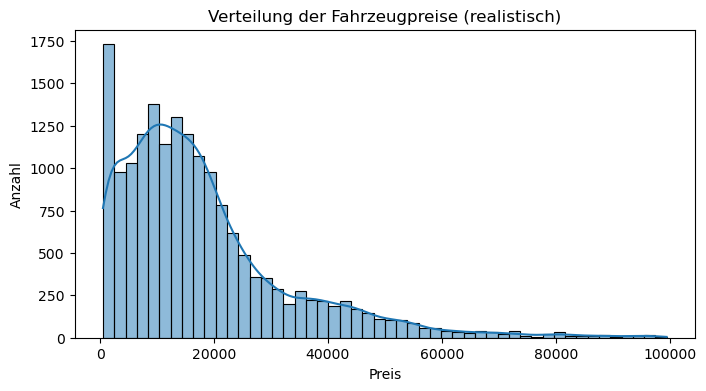

In [72]:
# Korrelationen anzeigen
df_no_extremes = df[df["Price"] >= 500]

plt.figure(figsize=(8, 4))
sns.histplot(df_no_extremes[df_no_extremes["Price"] < 100000]["Price"], kde=True, bins=50)
plt.title("Verteilung der Fahrzeugpreise (realistisch)")
plt.xlabel("Preis")
plt.ylabel("Anzahl")
plt.show()


/tmp/ipykernel_10694/3895181212.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_top, x="Manufacturer", y="Price", estimator='mean', ci=None)


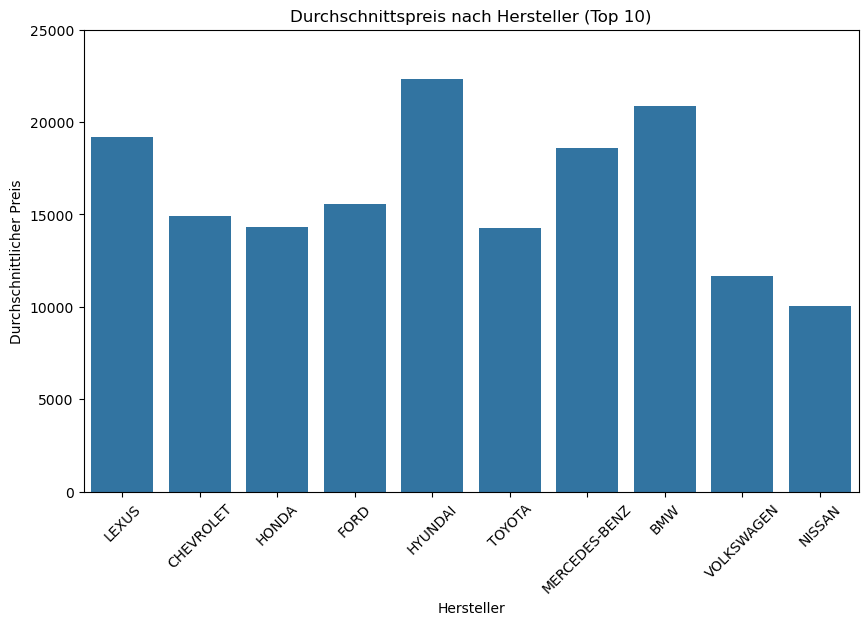

In [73]:
# Nur Top 10 Hersteller anzeigen, Durchschnittspreis
top_manu = df["Manufacturer"].value_counts().head(10).index
df_top = df[df["Manufacturer"].isin(top_manu)]

plt.figure(figsize=(10, 6))
sns.barplot(data=df_top, x="Manufacturer", y="Price", estimator='mean', ci=None)
plt.ylim(0, 25000)
plt.xticks(rotation=45)
plt.title("Durchschnittspreis nach Hersteller (Top 10)")
plt.ylabel("Durchschnittlicher Preis")
plt.xlabel("Hersteller")
plt.show()


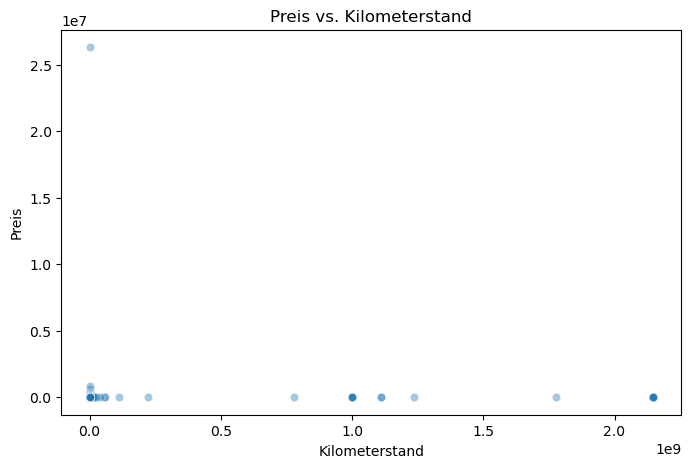

In [74]:
# Scatterplot von Preis vs. Kilometerstand inkl. Ausreißer-Daten
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="Mileage", y="Price", alpha=0.4)
plt.title("Preis vs. Kilometerstand")
plt.xlabel("Kilometerstand")
plt.ylabel("Preis")
plt.show()


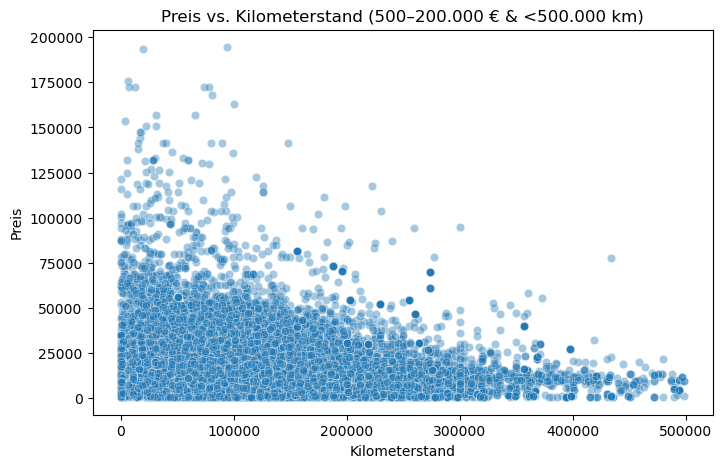

In [75]:
# Filter für realistische Preise und Kilometerstände ab 500 bis 200.000 Euro
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered = df[
    (df["Price"] >= 500) & (df["Price"] < 200000) &
    (df["Mileage"] < 500000)
]

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_filtered, x="Mileage", y="Price", alpha=0.4)
plt.title("Preis vs. Kilometerstand (500–200.000 € & <500.000 km)")
plt.xlabel("Kilometerstand")
plt.ylabel("Preis")
plt.show()


In [76]:
# Anzahl der Autos mit Preis unter 100 €
anzahl_unter_100 = df[df["Price"] < 100].shape[0]

print(f"Anzahl der Autos mit Preis unter 100 €: {anzahl_unter_100}")

Anzahl der Autos mit Preis unter 100 €: 356


In [77]:
#Welche Hersteller haben Autos mit Preis unter 100 €?
df[df["Price"] < 100]["Manufacturer"].value_counts()

Manufacturer
TOYOTA           115
HONDA             98
HYUNDAI           30
NISSAN            27
MERCEDES-BENZ     25
LEXUS             13
BMW               11
MITSUBISHI         8
VOLKSWAGEN         5
SUBARU             4
MAZDA              4
FORD               4
KIA                2
OPEL               2
CHEVROLET          2
JAGUAR             1
DODGE              1
SUZUKI             1
PORSCHE            1
ACURA              1
HUMMER             1
Name: count, dtype: int64

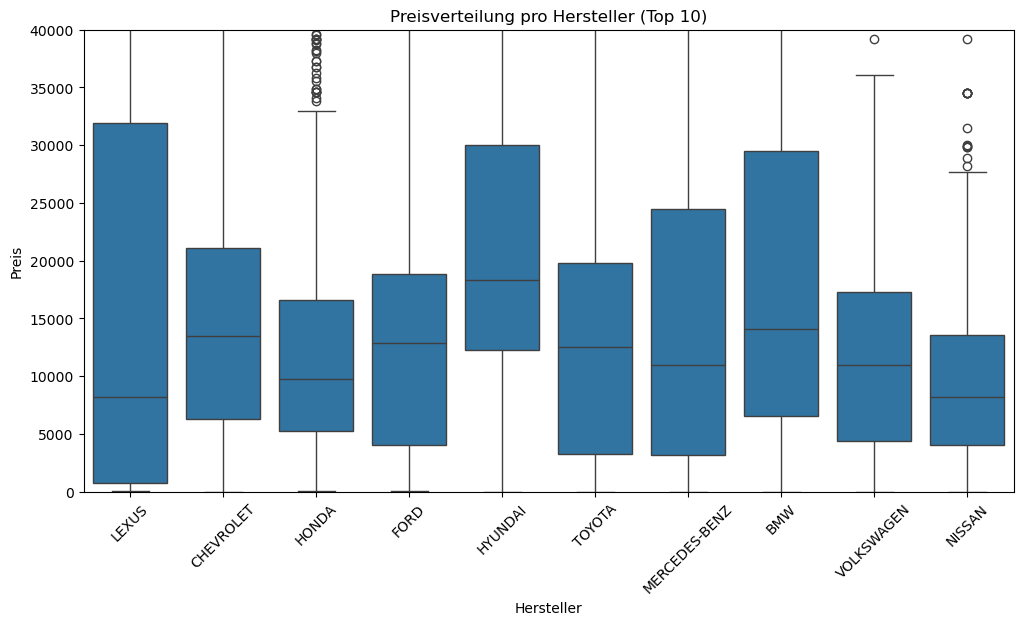

In [78]:
# Preisverteilung pro Hersteller (Top 10)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df["Manufacturer"].isin(df["Manufacturer"].value_counts().head(10).index)],
            x="Manufacturer", y="Price")
plt.ylim(0, 40000)
plt.xticks(rotation=45)
plt.title("Preisverteilung pro Hersteller (Top 10)")
plt.ylabel("Preis")
plt.xlabel("Hersteller")
plt.show()


/tmp/ipykernel_10694/2469984359.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="Fuel type", y="Price", estimator='mean', ci=None)


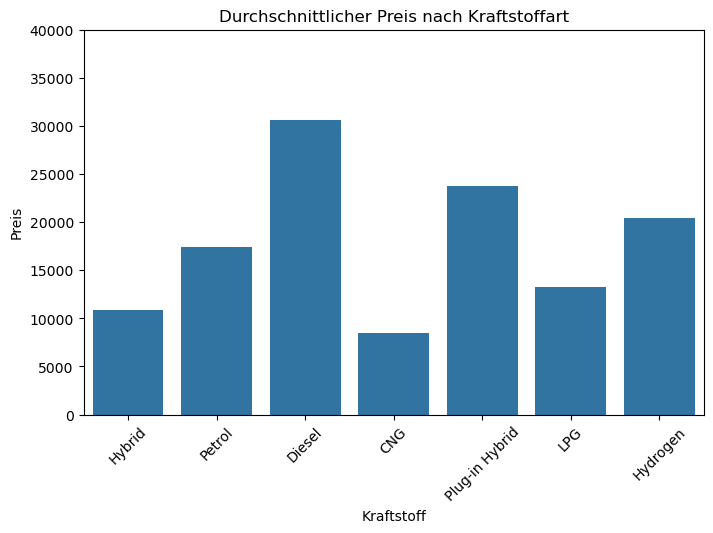

In [79]:
#Durchschnittspreis nach Kraftstoffart
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="Fuel type", y="Price", estimator='mean', ci=None)
plt.title("Durchschnittlicher Preis nach Kraftstoffart")
plt.ylabel("Preis")
plt.xlabel("Kraftstoff")
plt.xticks(rotation=45)
plt.ylim(0, 40000)
plt.show()


/tmp/ipykernel_10694/2810113290.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="Gear box type", y="Price", estimator='mean', ci=None)


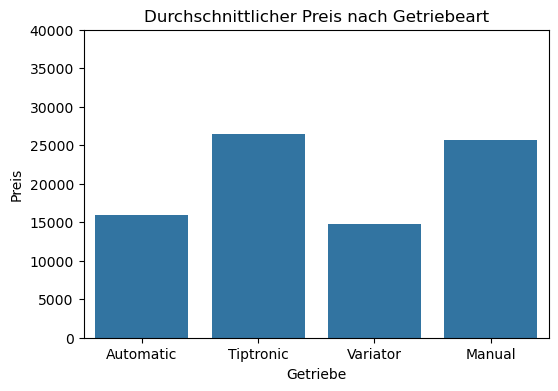

In [80]:
#Durchschnittspreis nach Getriebeart
plt.figure(figsize=(6, 4))
sns.barplot(data=df, x="Gear box type", y="Price", estimator='mean', ci=None)
plt.title("Durchschnittlicher Preis nach Getriebeart")
plt.xlabel("Getriebe")
plt.ylabel("Preis")
plt.ylim(0, 40000)
plt.show()


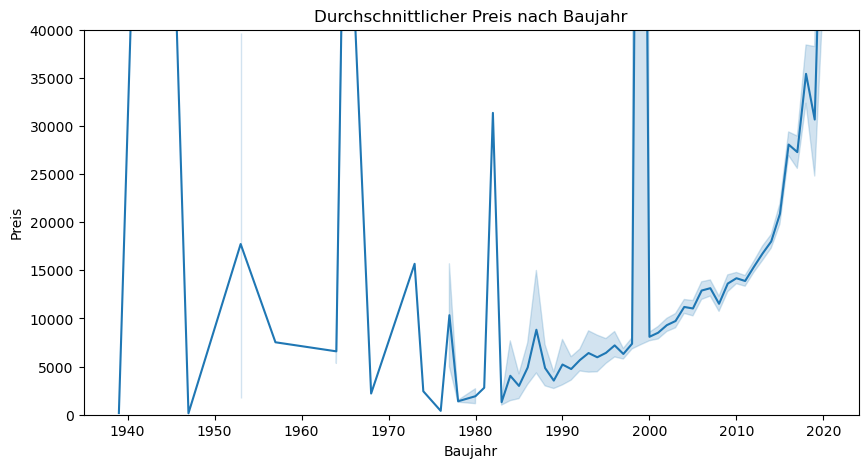

In [81]:
# Preisentwicklung nach Baujahr
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="Prod. year", y="Price")
plt.title("Durchschnittlicher Preis nach Baujahr")
plt.xlabel("Baujahr")
plt.ylabel("Preis")
plt.ylim(0, 40000)
plt.show()


In [ ]:
#---
# Fahrzeugpreis Vorhersage mit Linearer Regression

In [88]:
# Realistische Daten filtern VOR feature-Auswahl
df = df[
    (df["Price"] >= 500) & (df["Price"] < 100000) &
    (df["Mileage"] > 100) & (df["Mileage"] < 500000)
]


In [89]:
# Nur die gewünschten Spalten auswählen
features = ["Mileage", "Prod. year", "Engine volume", "Cylinders", "Airbags"]
X = df[features]

# Zielvariable: Preis
y = df["Price"]


In [90]:
from sklearn.model_selection import train_test_split

# Aufteilen der Daten in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [91]:
from sklearn.linear_model import LinearRegression

# Modell erstellen
model = LinearRegression()

# Modell mit den Trainingsdaten trainieren
model.fit(X_train, y_train)


LinearRegression()

In [92]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Preisvorhersage mit Testdaten
y_pred = model.predict(X_test)

# Modellbewertung
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE (durchschnittlicher Fehler): {mae:.2f} €")
print(f"RMSE (Wurzel aus mittlerem quadratischen Fehler): {rmse:.2f} €")
print(f"R² (Erklärte Varianz): {r2:.3f}")


MAE (durchschnittlicher Fehler): 9290.77 €
RMSE (Wurzel aus mittlerem quadratischen Fehler): 12992.98 €
R² (Erklärte Varianz): 0.223


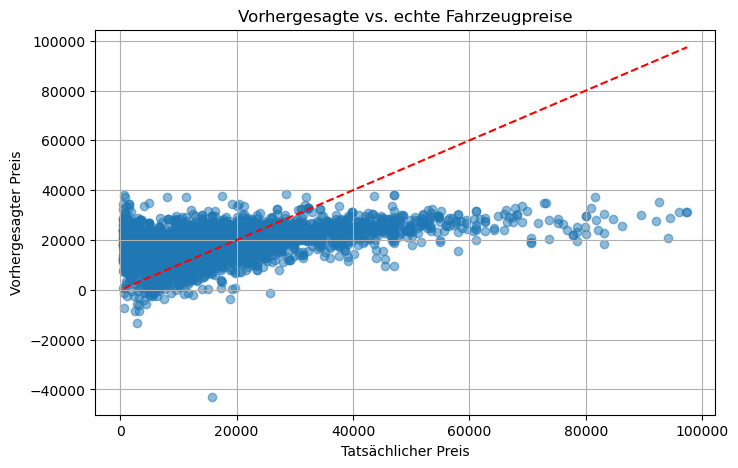

In [93]:
# Preisvergleich zwischen Vorhersage und tatsächlichem Preis
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonale
plt.xlabel("Tatsächlicher Preis")
plt.ylabel("Vorhergesagter Preis")
plt.title("Vorhergesagte vs. echte Fahrzeugpreise")
plt.grid(True)
plt.show()


In [94]:
#Random Forest Regressor ein besseres Modell?
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Modell erstellen
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Modell trainieren
rf_model.fit(X_train, y_train)

# Vorhersage
y_pred_rf = rf_model.predict(X_test)

# Bewertung
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

print(f"MAE (durchschnittlicher Fehler): {mae:.2f} €")
print(f"RMSE (Wurzel aus mittlerem quadratischen Fehler): {rmse:.2f} €")
print(f"R² (Erklärte Varianz): {r2:.3f}")


MAE (durchschnittlicher Fehler): 5797.68 €
RMSE (Wurzel aus mittlerem quadratischen Fehler): 10027.67 €
R² (Erklärte Varianz): 0.537


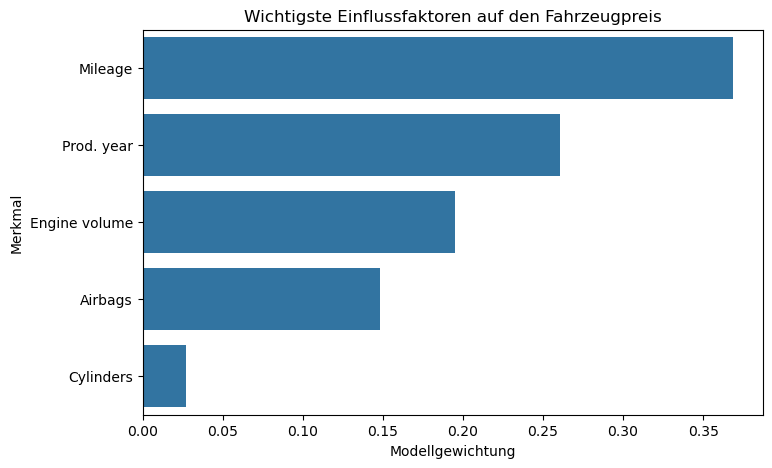

In [95]:
# Wichtigkeit der Merkmale abrufen
importances = rf_model.feature_importances_

# Namen der Features
feature_names = X.columns

# In DataFrame packen und sortieren
importances_df = pd.DataFrame({
    "Merkmal": feature_names,
    "Wichtigkeit": importances
}).sort_values(by="Wichtigkeit", ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=importances_df, x="Wichtigkeit", y="Merkmal")
plt.title("Wichtigste Einflussfaktoren auf den Fahrzeugpreis")
plt.xlabel("Modellgewichtung")
plt.ylabel("Merkmal")
plt.show()


In [96]:
# Beispielauto
auto = pd.DataFrame([{
    "Mileage": 85000,
    "Prod. year": 2016,
    "Engine volume": 1.6,
    "Cylinders": 4,
    "Airbags": 6
}])

# Vorhersage mit Random-Forest-Modell
preis_vorhersage = rf_model.predict(auto)

print(f"Vorhergesagter Preis für dieses Auto: {preis_vorhersage[0]:.2f} €")


Vorhergesagter Preis für dieses Auto: 16221.37 €
